BLDG 5301 Project

In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import optimize
from sklearn import linear_model
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

In [18]:
# Load all the provided CSV files
weather_data_path = "weather.csv"
ahu1_data_path = "canal ahu 1.csv"
ahu2_data_path = "canal ahu 2.csv"
energy_data_path = "canal energy use.csv"

# Read the files into pandas DataFrames
weather_data = pd.read_csv(weather_data_path)
ahu1_data = pd.read_csv(ahu1_data_path)
ahu2_data = pd.read_csv(ahu2_data_path)
energy_data = pd.read_csv(energy_data_path)

# Rename and convert timestamp columns to datetime format for all datasets
weather_data.rename(columns={"Unnamed: 0": "Timestamp"}, inplace=True)
weather_data["Timestamp"] = pd.to_datetime(weather_data["Timestamp"])

ahu1_data.rename(columns={"Unnamed: 0": "Timestamp"}, inplace=True)
ahu1_data["Timestamp"] = pd.to_datetime(ahu1_data["Timestamp"])

ahu2_data.rename(columns={"Unnamed: 0": "Timestamp"}, inplace=True)
ahu2_data["Timestamp"] = pd.to_datetime(ahu2_data["Timestamp"])

energy_data.rename(columns={"Unnamed: 0": "Timestamp"}, inplace=True)
energy_data["Timestamp"] = pd.to_datetime(energy_data["Timestamp"])

# Set the Timestamp column as the index for all datasets
weather_data.set_index("Timestamp", inplace=True)
ahu1_data.set_index("Timestamp", inplace=True)
ahu2_data.set_index("Timestamp", inplace=True)
energy_data.set_index("Timestamp", inplace=True)

# Identify missing timestamps for each dataset compared to the weather data
missing_ahu1 = weather_data.index.difference(ahu1_data.index)
missing_ahu2 = weather_data.index.difference(ahu2_data.index)
missing_energy = weather_data.index.difference(energy_data.index)

# Print the missing timestamps neatly
print("Missing Timestamps in AHU 1 data:")
print(missing_ahu1)

print("\nMissing Timestamps in AHU 2 data:")
print(missing_ahu2)

print("\nMissing Timestamps in Energy Use data:")
print(missing_energy)

# Save the new data to an Excel file
output_file_path = "Clean_Weather.csv"  # Specify your desired output path
weather_data.to_csv(output_file_path, index=False)

print(f"New CSV file created: {output_file_path}")


Missing Timestamps in AHU 1 data:
DatetimeIndex([], dtype='datetime64[ns]', name='Timestamp', freq=None)

Missing Timestamps in AHU 2 data:
DatetimeIndex([], dtype='datetime64[ns]', name='Timestamp', freq=None)

Missing Timestamps in Energy Use data:
DatetimeIndex([], dtype='datetime64[ns]', name='Timestamp', freq=None)
New CSV file created: Clean_Weather.csv


In [14]:
import pandas as pd

# Load the uploaded CSV file
file_path = "canal energy use.csv"  # Replace with the actual path to your input file
data = pd.read_csv(file_path)

# Rename the timestamp column for clarity
# Assuming the timestamp column is unnamed, we rename it to 'Timestamp'
data.rename(columns={"Unnamed: 0": "Timestamp"}, inplace=True)

# Calculate the 'Total Chiller' column by summing 'Chiller 1' and 'Chiller 2'
data["Total Chiller"] = data["Chiller 1"] + data["Chiller 2"]

# Calculate the 'Total AHU' column by summing 'AHU 1' and 'AHU 2'
data["Total AHU"] = data["AHU 1"] + data["AHU 2"]

# Calculate the 'Total Plugs' column by summing all the plug columns
plug_columns = ["Plug 1", "Plug 2", "Plug 3", "Plug 4", "Plug 5", "Plug 6"]
data["Total Plugs"] = data[plug_columns].sum(axis=1)

# Calculate the 'Total Lighting' column by summing all the lighting columns
lighting_columns = [
    "Lighting 1",
    "Lighting 2",
    "Lighting 3",
    "Lighting 4",
    "Lighting 5",
    "Lighting 6",
]
data["Total Lighting"] = data[lighting_columns].sum(axis=1)

# Create a new DataFrame with only the required columns
cleaned_data = data[
    ["Timestamp", "Total Chiller", "Total AHU", "Total Plugs", "Total Lighting"]
]

# Save the new data to an Excel file
output_file_path = "Canal_Clean_Energy_Use.xlsx"  # Specify your desired output path
cleaned_data.to_excel(output_file_path, index=False)

print(f"New Excel file created: {output_file_path}")


New Excel file created: Canal_Clean_Energy_Use.xlsx


In [15]:
import pandas as pd

# Load the Excel file
file_path = "Canal_Clean_Energy_Use.xlsx"  # Replace with the path to your Excel file
df = pd.read_excel(file_path)

# Create the 'Heating' column: AHU values where Chiller is 0 and AHU > 0
df["Heating"] = df["Total AHU"].where(
    (df["Total Chiller"] == 0) & (df["Total AHU"] > 0), 0
)

# Create the 'Cooling' column: AHU values where Chiller > 0 and AHU > 0
df["Cooling"] = df["Total AHU"].where(
    (df["Total Chiller"] > 0) & (df["Total AHU"] > 0), 0
)

# Save the updated DataFrame back to an Excel file
output_file_path = "Canal_Clean_Energy_Use_with_Heating_and_Cooling.xlsx"  # Specify your desired output path
df.to_excel(output_file_path, index=False)

print(
    "New columns 'Heating' and 'Cooling' added with corresponding values from 'Total AHU'."
)


New columns 'Heating' and 'Cooling' added with corresponding values from 'Total AHU'.


# Three-parameter univariate change point (CP) model predicting hourly heating and cooling

Fitted parameters: [ -0.3020532   99.03325104 -18.57534533]


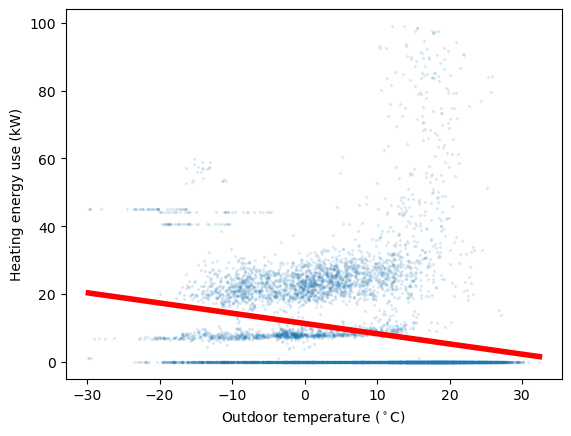

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# Read the energy use data file for 2018
energy = pd.read_excel("Canal_Clean_Energy_Use_with_Heating_and_Cooling.xlsx")
energy["Timestamp"] = pd.to_datetime(energy["Timestamp"])

# Read the weather data file for 2017
weather = pd.read_csv("weather.csv")
weather["Timestamp"] = pd.to_datetime(weather["Timestamp"])

# Merge datasets on the Timestamp column to align data
data = pd.merge(energy, weather, on="Timestamp", how="inner")

# Ensure no missing values in relevant columns
data = data.dropna(subset=["T2M", "Heating"])

# Scatter plot
plt.scatter(data["T2M"], data["Heating"], s=2, alpha=0.1)
plt.xlabel("Outdoor temperature ($^\\circ$C)")
plt.ylabel("Heating energy use (kW)")


# Define the change point model structure as a function
def cpm_three_prmtr(x, a, b, c):
    # Linear decrease below b, flat at c above b
    return np.where(x < b, a * (x - b) + c,c)


# Train the model using the least squares method
params, params_covariance = optimize.curve_fit(
    cpm_three_prmtr, data["T2M"], data["Heating"], p0=[-1, 10, 5]
)

# Plot the fitted curve
x_vals = np.linspace(data["T2M"].min(), data["T2M"].max(), num=100)
plt.plot(
    x_vals,
    cpm_three_prmtr(x_vals, params[0], params[1], params[2]),
    "r-",
    linewidth=4,
)

print("Fitted parameters:", params)
plt.show()


In [ ]:
# Align the datasets on timestamps
aligned_data = pd.merge(
    energy[["Timestamp", "Heating"]],  # Select relevant columns
    weather[["Timestamp", "T2M"]],
    on="Timestamp",
    how="inner",  # Keep only matching timestamps
)

# Ensure no missing values
aligned_data.dropna(subset=["T2M", "Heating"], inplace=True)

# Extract aligned arrays
t2m = aligned_data["T2M"]
heating = aligned_data["Heating"]

# Calculate residuals using the change point model
residuals_heating = cpm_three_prmtr(t2m, params[0], params[1], params[2]) - heating

# Calculate RMSE and CV(RMSE)
rmse_heating = np.sqrt(np.mean(residuals_heating**2))
cv_rmse_heating = rmse_heating / np.mean(heating) * 100
print(f"- CV(RMSE) - Heating: {round(cv_rmse_heating)}%")

# Calculate NMBE
nmbe_heating = np.mean(residuals_heating) / np.mean(heating) * 100
print(f"- NMBE - Heating: {round(nmbe_heating)}%")


- CV(RMSE) - Heating: 155%
- NMBE - Heating: 0%


Fitted parameters: [1.57306725 8.36026092 0.34945681]


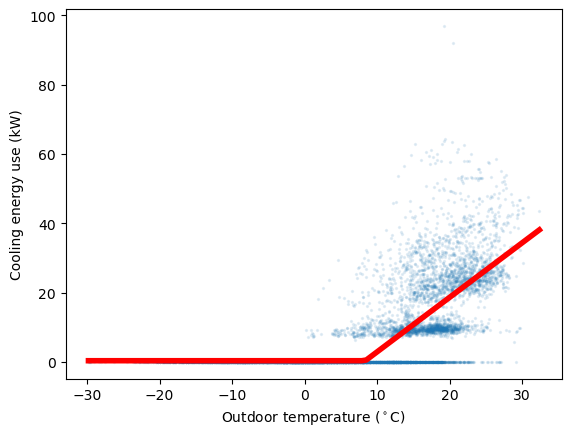

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

# Read the energy use data file for 2018
energy = pd.read_excel("Canal_Clean_Energy_Use_with_Heating_and_Cooling.xlsx")
energy["Timestamp"] = pd.to_datetime(energy["Timestamp"])

# Read the weather data file for 2017
weather = pd.read_csv("weather.csv")
weather["Timestamp"] = pd.to_datetime(weather["Timestamp"])

# Merge datasets on the Timestamp column to align data
data = pd.merge(energy, weather, on="Timestamp", how="inner")

# Ensure no missing values in relevant columns
data = data.dropna(subset=["T2M", "Cooling"])

# Scatter plot
plt.scatter(data["T2M"], data["Cooling"], s=2, alpha=0.1)
plt.xlabel("Outdoor temperature ($^\\circ$C)")
plt.ylabel("Cooling energy use (kW)")


# Define the change point model structure as a function
def cpm_three_prmtr(x, a, b, c):
    # Linear decrease below b, flat at c above b
    return np.where(x > b, a * (x - b) + c, c)


# Train the model using the least squares method
params, params_covariance = optimize.curve_fit(
    cpm_three_prmtr, data["T2M"], data["Cooling"], p0=[-1, 10, 5]
)

# Plot the fitted curve
x_vals = np.linspace(data["T2M"].min(), data["T2M"].max(), num=100)
plt.plot(
    x_vals,
    cpm_three_prmtr(x_vals, params[0], params[1], params[2]),
    "r-",
    linewidth=4,
)

print("Fitted parameters:", params)
plt.show()


In [26]:
# Align the datasets on timestamps
aligned_data = pd.merge(
    energy[["Timestamp", "Cooling"]],  # Select relevant columns
    weather[["Timestamp", "T2M"]],
    on="Timestamp",
    how="inner",  # Keep only matching timestamps
)

# Ensure no missing values
aligned_data.dropna(subset=["T2M", "Cooling"], inplace=True)

# Extract aligned arrays
t2m = aligned_data["T2M"]
cooling = aligned_data["Cooling"]

# Calculate residuals using the change point model
residuals_cooling = cpm_three_prmtr(t2m, params[0], params[1], params[2]) - cooling

# Calculate RMSE and CV(RMSE)
rmse_cooling = np.sqrt(np.mean(residuals_cooling**2))
cv_rmse_cooling = rmse_cooling / np.mean(cooling) * 100
print(f"- CV(RMSE) - Cooling: {round(cv_rmse_cooling)}%")

# Calculate NMBE
nmbe_cooling = np.mean(residuals_cooling) / np.mean(cooling) * 100
print(f"- NMBE - Cooling: {round(nmbe_cooling)}%")

- CV(RMSE) - Cooling: 195%
- NMBE - Cooling: 23%


# Neural Network

[145.3566718786618, 145.6300999338515, 157.27315397527755, 142.81141288227667, 145.5237688980483, 142.11889837537862]
[-2.153639984194637, 9.228394637979576, -1.9695454333357905, 17.468371171406034, 6.960445956901526, 1.4995645297109066]


Text(0, 0.5, 'CV(RMSE) (%)')

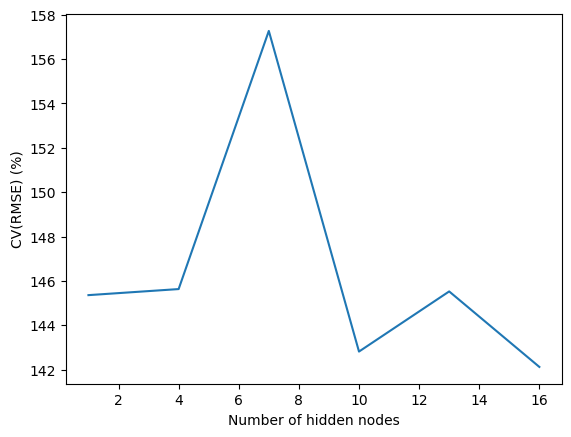

In [30]:
cv_rmse = []
nmbe = []
for i in range (1,19,3):
    params = { 'hidden_layer_sizes' : [i,i],
        'activation' : 'relu', 'solver' : 'adam',
        'alpha' : 0.0, 'batch_size' : 10,
        'random_state' : 0, 'tol' : 0.0001,
        'nesterovs_momentum' : False,
        'learning_rate' : 'constant',
        'learning_rate_init' : 0.01,
        'max_iter' : 1000, 'shuffle' : True,
        'n_iter_no_change' : 50, 'verbose' : False }

    net = MLPRegressor(**params)


    X = pd.concat([weather['T2M'],weather['RH2M']],axis = 1)
    y = energy['Heating']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    net.fit(X_train,y_train)

    residuals = net.predict(X_test) -  y_test
    rmse = np.sqrt(np.mean((residuals**2)))
    cv_rmse.append(rmse/np.mean(y_test)*100)
    nmbe.append(np.mean(residuals)/np.mean(y_test)*100)
    
print(cv_rmse)
print(nmbe)

plt.plot(np.linspace(1,16,6),cv_rmse)
plt.xlabel("Number of hidden nodes")
plt.ylabel("CV(RMSE) (%)")

[103.25942042828696, 102.5742676700296, 158.69797774013844, 103.82875684005988, 102.65514993391626, 109.55593400123867]
[-4.624923472351961, 3.955196039022648, 0.47049304933337727, -10.079152564340458, 4.626660620149599, -25.829834293056386]


Text(0, 0.5, 'CV(RMSE) (%)')

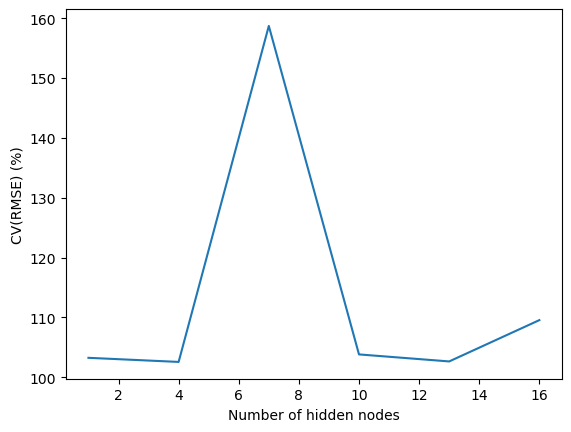

In [31]:

cv_rmse = []
nmbe = []
for i in range (1,19,3):
    params = { 'hidden_layer_sizes' : [i,i],
        'activation' : 'relu', 'solver' : 'adam',
        'alpha' : 0.0, 'batch_size' : 10,
        'random_state' : 0, 'tol' : 0.0001,
        'nesterovs_momentum' : False,
        'learning_rate' : 'constant',
        'learning_rate_init' : 0.01,
        'max_iter' : 1000, 'shuffle' : True,
        'n_iter_no_change' : 50, 'verbose' : False }

    net = MLPRegressor(**params)

    X1 = pd.concat([weather['T2M'],weather['RH2M']],axis = 1)
    y1 = energy['Cooling']

    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=0)

    net.fit(X1_train,y1_train)

    residuals = net.predict(X1_test) -  y1_test
    rmse = np.sqrt(np.mean((residuals**2)))
    cv_rmse.append(rmse/np.mean(y1_test)*100)
    nmbe.append(np.mean(residuals)/np.mean(y1_test)*100)
    
print(cv_rmse)
print(nmbe)

plt.plot(np.linspace(1,16,6),cv_rmse)
plt.xlabel("Number of hidden nodes")
plt.ylabel("CV(RMSE) (%)")